In [61]:
import numpy as np
import pandas as pd
import seaborn
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from experiments.libs.loaders import load_bci
from experiments.libs.timer import Timer

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
pipeline_steps = [('scale', StandardScaler())]
continuous_pipeline = Pipeline(steps=pipeline_steps)

In [8]:
featurisers = [('continuous', continuous_pipeline)]

In [9]:
xgb_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', XGBClassifier(max_depth=3, 
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                gamma=0.1,
                                                                subsample=1))])

In [91]:
lgbm_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', LGBMClassifier(num_leaves=2**3, 
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                subsample=1))])

In [13]:
X, y, X_test, y_test = load_bci()

In [43]:
from tqdm import tqdm_notebook, tqdm

In [56]:
def run_train_retrain_comparison(model, X, y, X_test, y_test):
    retrain_model = deepcopy(model)
    historical_X = deepcopy(X.tolist())
    historical_y = deepcopy(y.tolist())
    train_auc=[]
    retrain_auc=[]
    for X_test_run, y_test_run in  tqdm_notebook(zip(X_test, y_test), total=len(y_test)):
        prev_model = deepcopy(retrain_model)
        
        y_pred = model.predict_proba(X_test_run)
        train_auc.append(roc_auc_score(y_test_run, y_pred[:, 1]))

        y_pred = retrain_model.predict_proba(X_test_run)
        retrain_auc.append(roc_auc_score(y_test_run, y_pred[:, 1]))

        historical_X.append(X_test_run)
        historical_y.append(y_test_run)

        new_train_X  = np.concatenate(historical_X)
        retrain_model.fit(new_train_X, np.concatenate(historical_y))
        
    return pd.DataFrame({
        'train_auc':train_auc,
        'retrain_auc':retrain_auc
    })

In [57]:
xgb_clf_pipeline.fit(np.concatenate(X),np.concatenate(y))

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None)), ('clf', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=2, seed=0, silent=True, subsample=1))])

In [70]:
with Timer() as t:
    df = run_train_retrain_comparison(xgb_clf_pipeline, X, y, X_test, y_test)

In [71]:
results_dict={}

In [72]:
results_dict['xgb']={
    'time': t.interval,
    'results': df
}

In [93]:
lgbm_clf_pipeline.fit(np.concatenate(X),np.concatenate(y))

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None)), ('clf', LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, drop_rate=0.1,
        is_un...   subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False))])

In [94]:
with Timer() as t:
    df = run_train_retrain_comparison(lgbm_clf_pipeline, X, y, X_test, y_test)

In [95]:
results_dict['lgbm']={
    'time': t.interval,
    'results': df
}

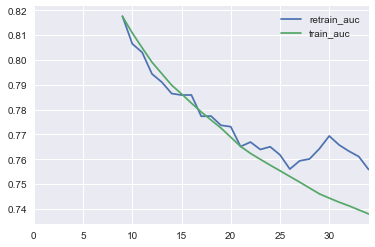

In [96]:
results_dict['xgb']['results'].rolling(window=10).mean().plot()

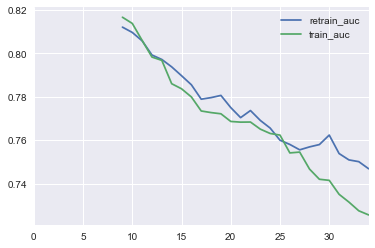

In [97]:
results_dict['lgbm']['results'].rolling(window=10).mean().plot()

In [98]:
results_dict['xgb']['results'].mean()

retrain_auc    0.779121
train_auc      0.772237
dtype: float64

In [99]:
results_dict['lgbm']['results'].mean()

retrain_auc    0.776037
train_auc      0.768168
dtype: float64